In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from collections import *

# Part 1

In [2]:
# dataset: [X, y]
dataset = sklearn.datasets.load_iris(return_X_y=True)

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
dataset = (scaler.fit_transform(*dataset), dataset[1])

# Split data
TRAIN_SPLIT = 0.8
train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(
    *dataset,
    train_size=TRAIN_SPLIT, test_size=1 - TRAIN_SPLIT,
    stratify=dataset[1],
    random_state=15
)

# Print input shape and target class distribution
print(f"X shape: {"x".join(map(str, dataset[0].shape))}")
print(f"y distribution:\n{"\n".join([f"\t{k}: {v / len(dataset[1]) * 100:.2f}%" for k, v in Counter(dataset[1]).items()])}")

# Functions to handle each problem
def get_classes(y):
    return np.array([c for c in set(y)])
def convert_y(y, c, classes):
    return (y[:] == c).astype(np.int8)
def logits_to_class(logits, classes):
    return classes[np.argmax(logits, axis=-1)]

X shape: 150x4
y distribution:
	0: 33.33%
	1: 33.33%
	2: 33.33%


# Part 2

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lr_model(X, w):
    return sigmoid(X @ w.T)

def lr_loss(X, y, w):
    y_hat = lr_model(X, w)
    return np.sum((y[:] * np.log(y_hat[:])) + ((1 - y[:]) * np.log(1 - y_hat[:])))

def lr_loss_grad(X, y, w):
    y_hat = lr_model(X, w)
    return (y - y_hat) @ X

def logistic_regression(X, y, learning_rate=0.0001, num_iterations=10_000):
    w = np.random.normal(size=X.shape[1])
    loss = np.ndarray(shape=num_iterations)
    for i in range(num_iterations):
        loss[i] = lr_loss(X, y, w)
        w += learning_rate * lr_loss_grad(X, y, w)
    return {
        "weights": w,
        "loss": loss,
        "accuracy": sum(np.round(lr_model(X, w)) == y) / len(y)
    }

def multi_class_logistic_regression(X, y, classes, **kwargs):
    results = [
        logistic_regression(X, convert_y(y, c, classes), **kwargs)
        for c in classes
    ]
    return {
        "weights": np.stack([r["weights"] for r in results]),
        "loss": np.stack([r["loss"] for r in results]).T,
        "accuracy": np.array([r["accuracy"] for r in results])
    }

Weights:
[[-0.96176213  2.54379818 -2.31506103 -3.10480077]
 [ 0.07484449 -1.10387291  1.05551078 -1.18360736]
 [-0.40655222  0.77299577  0.49765746  2.38142222]]
Final Loss:
	Total: -116.19262600484127
	Per-class: [ -3.55592228 -68.14542651 -44.49127721]
Loss curves


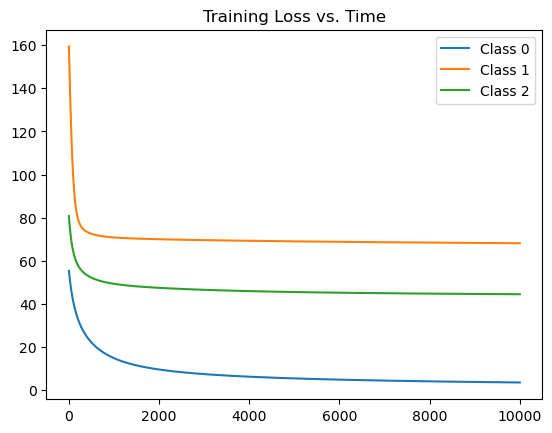

--------------------------------------------------
Predicted:
[0 1 0 1 1 1 1 1 0 2 1 1 2 0 2 1 0 2 0 2 2 1 0 1 0 1 1 0 0 2]
Actual:
[0 1 0 2 2 1 1 1 0 2 1 1 2 0 2 1 0 2 0 2 2 1 0 2 0 1 1 0 0 2]
Accuracy:
	Overall: 90.00%
	Per-class:
		0: 100.00%
		1: 69.17%
		2: 78.33%


In [4]:
classes = get_classes(dataset[1])
model = multi_class_logistic_regression(train_X, train_y, classes)
logits = lr_model(test_X, model["weights"])

print("Weights:")
print(model["weights"])
print("Final Loss:")
print(f"\tTotal: {sum(model["loss"][-1])}")
print(f"\tPer-class: {model["loss"][-1]}")
print("Loss curves")
plt.title("Training Loss vs. Time")
plt.plot(model["loss"] * -1)
plt.legend([f"Class {c}" for c in classes])
plt.show()

print("-" * 50)
print("Predicted:")
print(predicted := logits_to_class(logits, classes))
print("Actual:")
print(actual := test_y)
print("Accuracy:")
print(f"\tOverall: {sum(p == a for p, a in zip(predicted, actual)) / len(predicted) * 100:.2f}%")
print(f"\tPer-class:\n{"\n".join(f"\t\t{c}: {model["accuracy"][i] * 100:.2f}%" for i, c in enumerate(classes))}")

del logits, model, classes, predicted, actual